https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (185, 7)


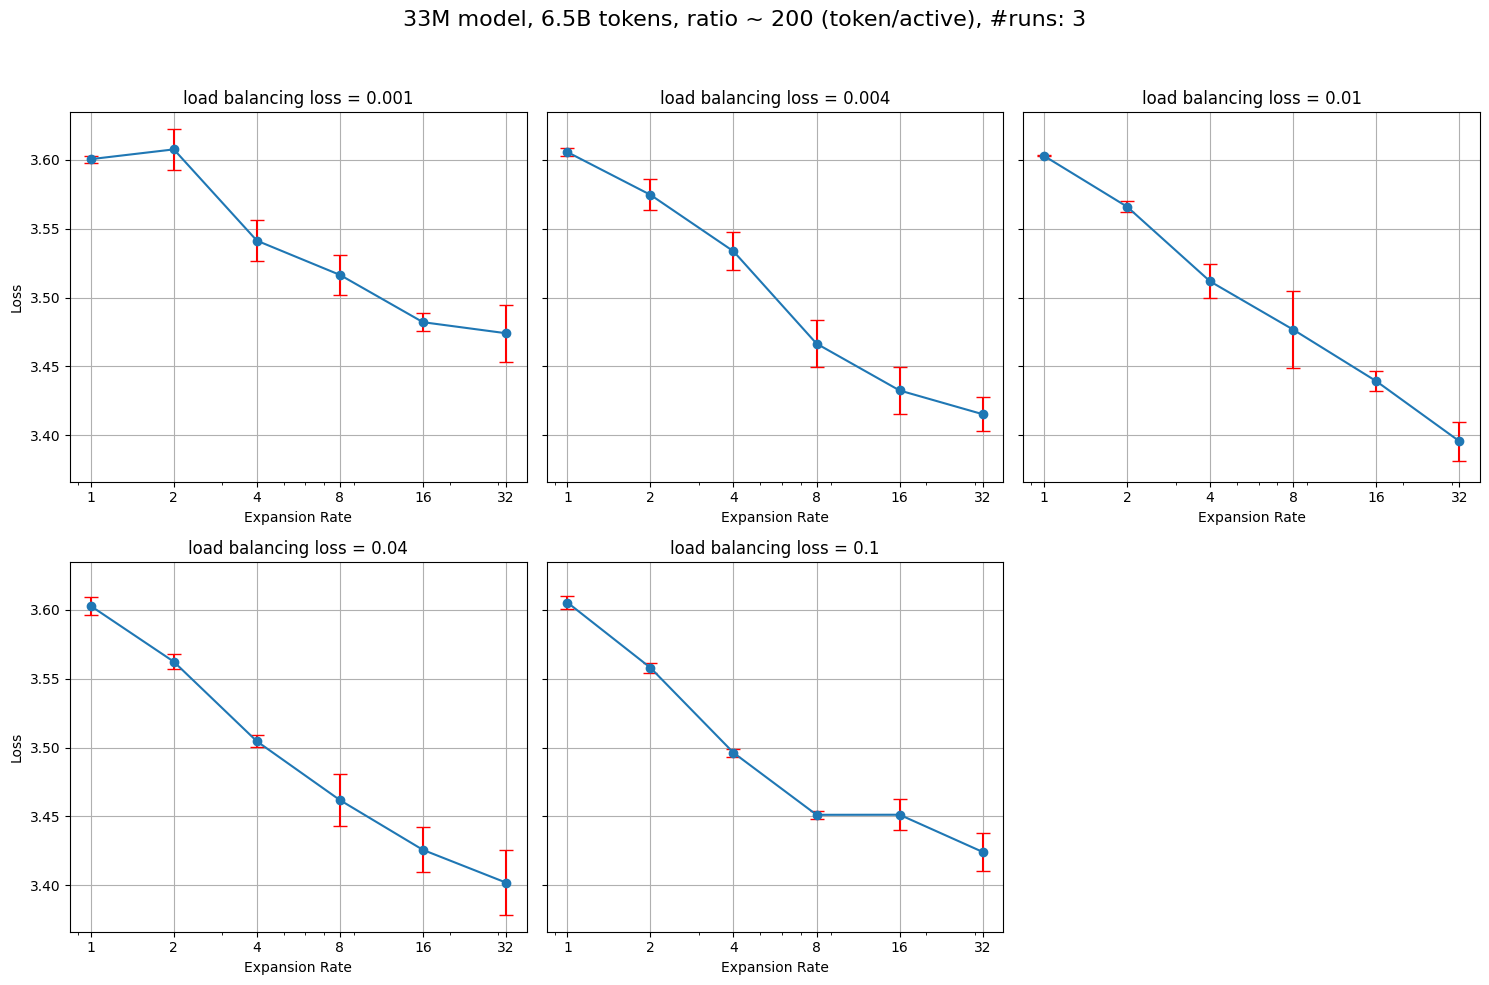

In [20]:
import neptune.new as neptune
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.ticker as ticker  # Import ticker for formatting

def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """
    # Initialize columns if None
    if columns is None:
        columns = []

    # Base columns to always include
    base_columns = ['sys/tags', 'sys/id', 'args/cutoff', 'args/batch_size', 'loss', 'args/expansion_rate', 'args/load_balancing_loss_weight']
    columns.extend(base_columns)

    # Mapping for 'start' and 'end' arguments
    prefix_mapping = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }

    # Components to include in the arguments columns
    components = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']

    # Build columns for each combination of 'start/end' and components
    for position in ['start', 'end']:
        for component in components:
            prefix = prefix_mapping[position]
            column_name = f'args/{prefix}/{component}'
            columns.append(column_name)

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="  # Replace with your actual API token or use an environment variable
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(
        tag=tags,
        columns=columns
    ).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    runs_table['sys/tags'] = runs_table['sys/tags'].apply(
        lambda x: x.split(',') if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table['sys/tags'].apply(lambda x: neg_tag in x)
            ]

    print(f'Table downloaded\nShape: {runs_table.shape}')
    return runs_table

# Step 1: Download the table with the correct columns
tags = ['bigger_E_better']  # Replace with your actual tags
negative_tags = None  # Replace with your negative tags if any
columns = []  # Additional columns if needed

# Get the runs table
runs_table = get_neptune_table(tags, negative_tags, columns)

# Step 2: Plotting the results
# Group data by 'args/load_balancing_loss_weight' and 'args/expansion_rate'
grouped = runs_table.groupby(['args/load_balancing_loss_weight', 'args/expansion_rate'])

# Calculate mean and standard deviation of the 'loss' for error bars
stats = grouped['loss'].agg(['mean', 'std']).reset_index()

# Get unique load balancing losses and expansion rates
lbl_values = sorted(stats['args/load_balancing_loss_weight'].unique())
exp_rates = sorted(stats['args/expansion_rate'].unique())

# Determine the number of subplots
num_subplots = len(lbl_values)

# Decide on the grid size (e.g., up to 3 columns)
ncols = min(num_subplots, 3)
nrows = math.ceil(num_subplots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

# Ensure axes is a flat array for easy indexing
if num_subplots == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Define the desired x-ticks
x_ticks = [1, 2, 4, 8, 16, 32]

# Calculate overall y-axis limits across all data
y_min = (stats['mean'] - stats['std']).min()
y_max = (stats['mean'] + stats['std']).max()

# Optional: Add a margin to y-limits for better visualization
y_margin = (y_max - y_min) * 0.05  # 5% margin
y_min -= y_margin
y_max += y_margin

# Plot for each load balancing loss (LBL)
for idx, lbl in enumerate(lbl_values):
    ax = axes[idx]
    subset = stats[stats['args/load_balancing_loss_weight'] == lbl]
    ax.errorbar(
        subset['args/expansion_rate'],
        subset['mean'],
        yerr=subset['std'],
        fmt='o-',
        ecolor='r',
        capsize=5
    )
    ax.set_title(f'load balancing loss = {lbl}')
    ax.set_xlabel('Expansion Rate')
    if idx % ncols == 0:
        # Only set y-label for left-most plots
        ax.set_ylabel('Loss')
    else:
        # Hide y-axis tick labels for other plots
        ax.set_yticklabels([])
        ax.set_ylabel('')
        ax.tick_params(axis='y', which='both', labelleft=False)
    ax.set_xscale('log')  # Set x-axis to log scale

    # Set x-ticks at specified points and format them as integers
    ax.set_xticks(x_ticks)
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='x', style='plain')
    ax.grid(True)

    # Set the same y-axis limits for all plots
    ax.set_ylim(y_min, y_max)

# Remove any unused subplots
if num_subplots < len(axes):
    for idx in range(num_subplots, len(axes)):
        fig.delaxes(axes[idx])

# Add a title to the entire figure
fig.suptitle('33M model, 6.5B tokens, ratio ~ 200 (token/active), #runs: 3', fontsize=16)

# Adjust the layout to make room for the figure title
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('jupyter_files/plots/bigger_E_better.pdf')
plt.show()